# Find and retrieve Sentinel-2 imagery

This notebook demonstrates how to:
- intersect Sentinel-2 scenes with a flight track using
[BigQuery](https://cloud.google.com/storage/docs/public-datasets/sentinel-2)
- retrieve and visualized Sentinel-2 scenes

This notebook relies on optional dependencies in the `sat` group (`pip install pycontrails[sat]`).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
from matplotlib import dates

from pycontrails.core import Flight
from pycontrails.datalib import sentinel

### Intersect Sentinel-2 scenes with IAGOS flight

Intersecting Sentinel-2 scenes with flight tracks requires a Google Cloud account and project with access to the [BigQuery API](https://cloud.google.com/bigquery?hl=en). Users without BigQuery API access can skip this section.

In [2]:
df = pd.read_csv("data/iagos-flight-sentinel.csv")
df["time"] = df["time"].apply(lambda t: pd.Timestamp(t))

In [3]:
flight = Flight(data=df).resample_and_fill("1min")

In [4]:
scenes = sentinel.intersect(flight)
scenes

,base_url,granule_id,sensing_time
5,gs://gcp-public-data-sentinel-2/tiles/30/U/WG/...,L1C_T30UWG_A014649_20191226T112436,2019-12-26 11:25:47.117000+00:00


### Retrieve and visualize Sentinel-2 scene

This section retrieves Landsat imagery from a [Google Cloud public dataset](https://cloud.google.com/storage/docs/public-datasets/sentinel-2). Retrieval uses anonymous access, so this section of the notebook can be run by users without a Google Cloud account.

`base_url`, `granule_id`, and `sensing_time` are hard-coded so this section can be run independently of the previous section.

In [5]:
base_url = "gs://gcp-public-data-sentinel-2/tiles/30/U/WG/S2B_MSIL1C_20191226T112359_N0208_R037_T30UWG_20191226T115227.SAFE"
granule_id = "L1C_T30UWG_A014649_20191226T112436"
sensing_time = pd.Timestamp("2019-12-26 11:25:47.117000+00:00")

The IAGOS flight is in an ISSR at the time of imagery acquisition:

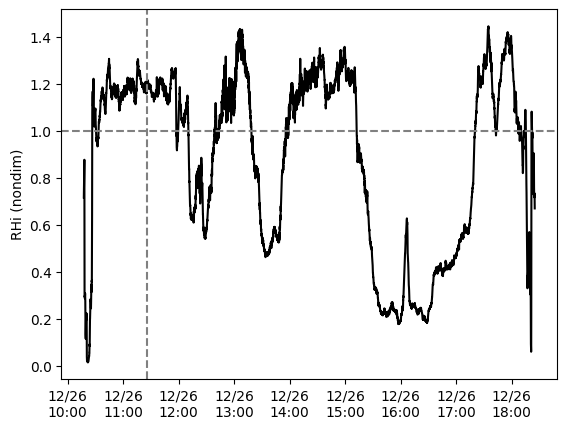

In [6]:
plt.plot(df["time"], df["rhi"], "k-")
plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%m/%d\n%H:%M"))
plt.gca().axhline(y=1, color="gray", ls="--")
plt.gca().axvline(x=sensing_time, color="gray", ls="--");

#### True-color image

We first download bands 02, 03, and 04. These are used to create a true-color image.

> Note that `handler.get` transfers satellite imagery from a Google Cloud bucket to your machine. This may take a while if you are running this notebook locally rather than on a Google Cloud VM.

In [7]:
handler = sentinel.Sentinel(base_url, granule_id, bands=["B02", "B03", "B04"])
ds = handler.get()
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (y: 10980, x: 10980)
Coordinates:
  * y        (y) float64 88kB 6.2e+06 6.2e+06 6.2e+06 ... 6.09e+06 6.09e+06
  * x        (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
Data variables:
    B02      (y, x) float32 482MB 0.9962 0.985 1.009 ... 0.8718 0.8674 0.8598
    B03      (y, x) float32 482MB 0.8292 0.832 0.831 ... 0.7194 0.7134 0.7148
    B04      (y, x) float32 482MB 0.933 0.9188 0.9322 ... 0.7936 0.8018 0.7992

We then generate and plot the true-color image.

In [8]:
rgb, crs, extent = sentinel.extract_sentinel_visualization(ds, color_scheme="true")

In [9]:
# crs artifact can be used to project flight latitude and longitude into image coordinates
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_lon = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: pd.Timestamp(t).timestamp()),
    df["longitude"],
)
flight_lat = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: pd.Timestamp(t).timestamp()),
    df["latitude"],
)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

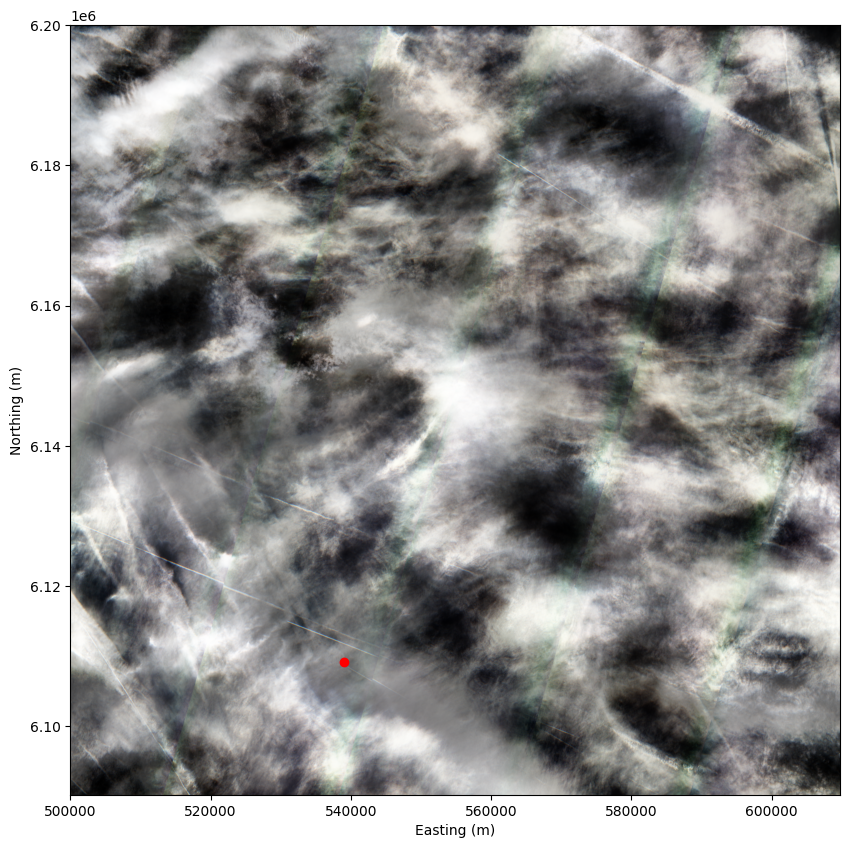

In [10]:
# seams in the image are from different detectors in the Sentinel-2 sensor
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

If we zoom in, we can see the aircraft and contrail! The aircraft is offset slightly from its projected position because Sentinel-2 imagery is geolocated at the surface.

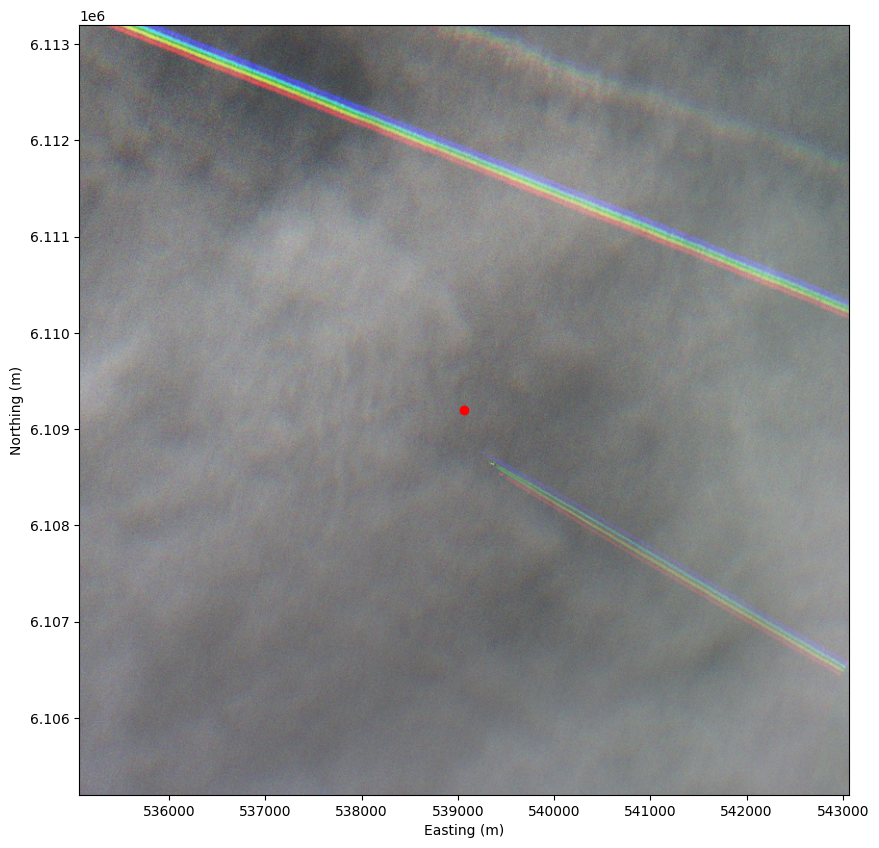

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlim([flight_x - 4e3, flight_x + 4e3])
plt.ylim([flight_y - 4e3, flight_y + 4e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

#### Cirrus band

Sentinel-2 does not have true longwave bands (i.e., bands where top-of-atmosphere radiances are dominated by emission rather than reflection). However, aircraft and contrails often show up clearly in the cirrus band (B10), which is designed to isolate high clouds.

This section also demonstrates plotting with the xarray Dataset returned by `Sentinel.get`.

In [12]:
handler = sentinel.Sentinel(base_url, granule_id, bands=["B10"])
ds = handler.get()

In [13]:
crs = ds["B10"].attrs["crs"]
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

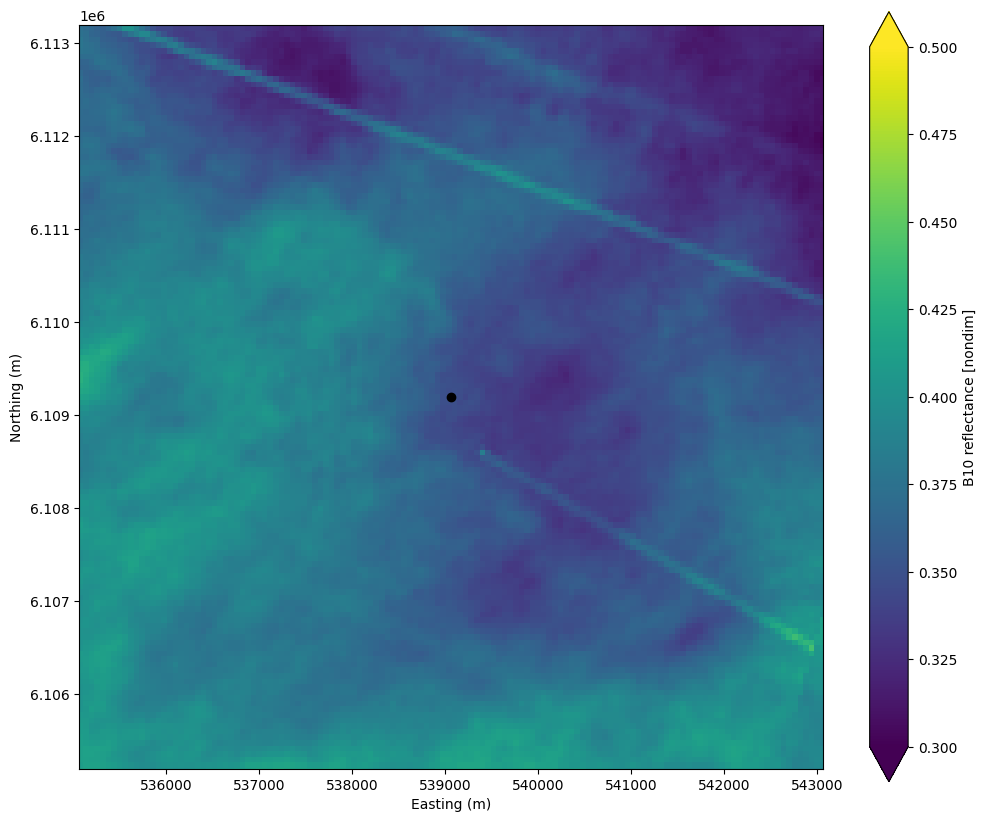

In [14]:
plt.figure(figsize=(12, 10))
ds["B10"].plot(vmin=0.3, vmax=0.5)
plt.gca().set_aspect("equal", "box")
plt.plot(flight_x, flight_y, "ko")
plt.xlim([flight_x - 4e3, flight_x + 4e3])
plt.ylim([flight_y - 4e3, flight_y + 4e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");